## EDA


##### imports


In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from ast import literal_eval
from collections import Counter
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from collections import Counter
import numpy as np
from scipy.stats import pointbiserialr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import NMF
from itertools import combinations
import math




In [22]:


DATA_PATH = Path(r"C:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\data\processed\dataset_clean.csv")  
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head(3)


(4040, 40)


,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,request_time_utc,request_text_original,request_text_edit_aware_original,request_title_original,request_text_length,request_text_word_count,request_text_edit_aware_length,request_text_edit_aware_word_count,request_title_length,request_title_word_count
0,NaN,0,1,False,t3_l25d7,0,hi i am in need of food for my 4 children we a...,hi i am in need of food for my 4 children we a...,request colorado springs help us please,0.0000,...,2011-10-05 21:10:07+00:00,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,316,67,316,67,39,6
1,NaN,2,5,False,t3_rcb83,0,i spent the last money i had on gas today. im ...,i spent the last money i had on gas today. im ...,"[request] california, no cash and i could use ...",501.1111,...,2012-03-25 04:13:44+00:00,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",74,16,74,16,57,10
2,NaN,0,3,False,t3_lpu5j,0,my girlfriend decided it would be a good idea ...,my girlfriend decided it would be a good idea ...,"[request] hungry couple in dundee, scotland wo...",0.0000,...,2011-10-26 16:28:14+00:00,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",277,59,277,59,66,10


##### simple audit


In [23]:
df.info(memory_usage="deep")     
df.isna().mean().sort_values(ascending=False).head(10)   


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 40 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   giver_username_if_known                               287 non-null    object 
 1   number_of_downvotes_of_request_at_retrieval           4040 non-null   int64  
 2   number_of_upvotes_of_request_at_retrieval             4040 non-null   int64  
 3   post_was_edited                                       4040 non-null   bool   
 4   request_id                                            4040 non-null   object 
 5   request_number_of_comments_at_retrieval               4040 non-null   int64  
 6   request_text                                          3932 non-null   object 
 7   request_text_edit_aware                               3932 non-null   object 
 8   request_title                                         4040

giver_username_if_known             0.928960
requester_user_flair                0.753960
request_text                        0.026733
request_text_edit_aware             0.026733
request_text_original               0.025743
request_text_edit_aware_original    0.025743
request_text_word_count             0.000000
request_text_edit_aware_length      0.000000
request_text_length                 0.000000
request_title_original              0.000000
dtype: float64

##### Target serie


Prévalence globale : 24.60%


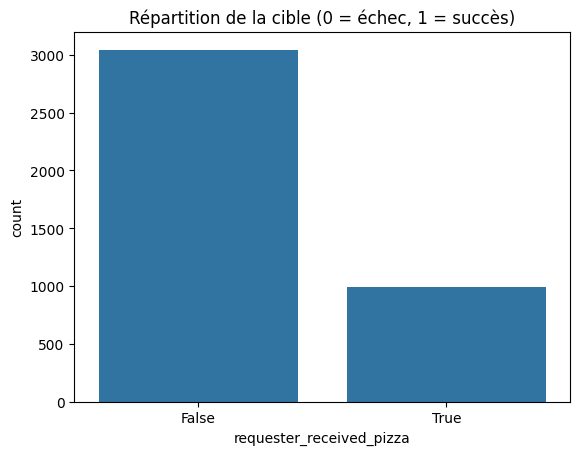

In [24]:


target_rate = df["requester_received_pizza"].mean()
print(f"Prévalence globale : {target_rate:.2%}")

sns.countplot(x="requester_received_pizza", data=df)
plt.title("Répartition de la cible (0 = échec, 1 = succès)")
plt.show()


C:\Users\mzouicha\AppData\Local\Temp\ipykernel_14124\1013230769.py:1: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

C:\Users\mzouicha\AppData\Local\Temp\ipykernel_14124\1013230769.py:4: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



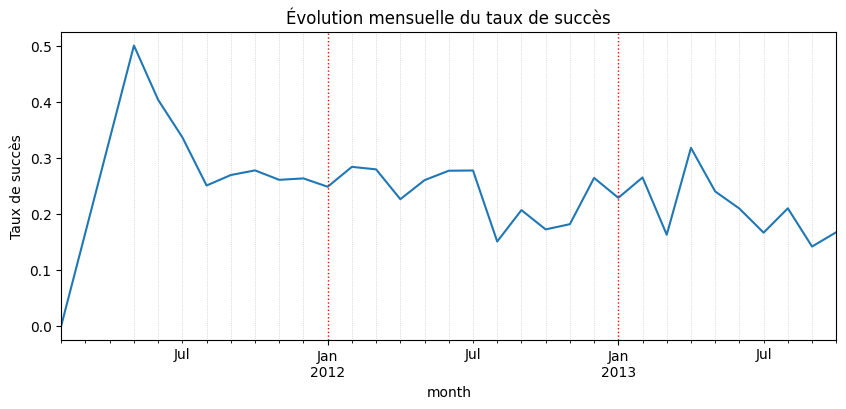

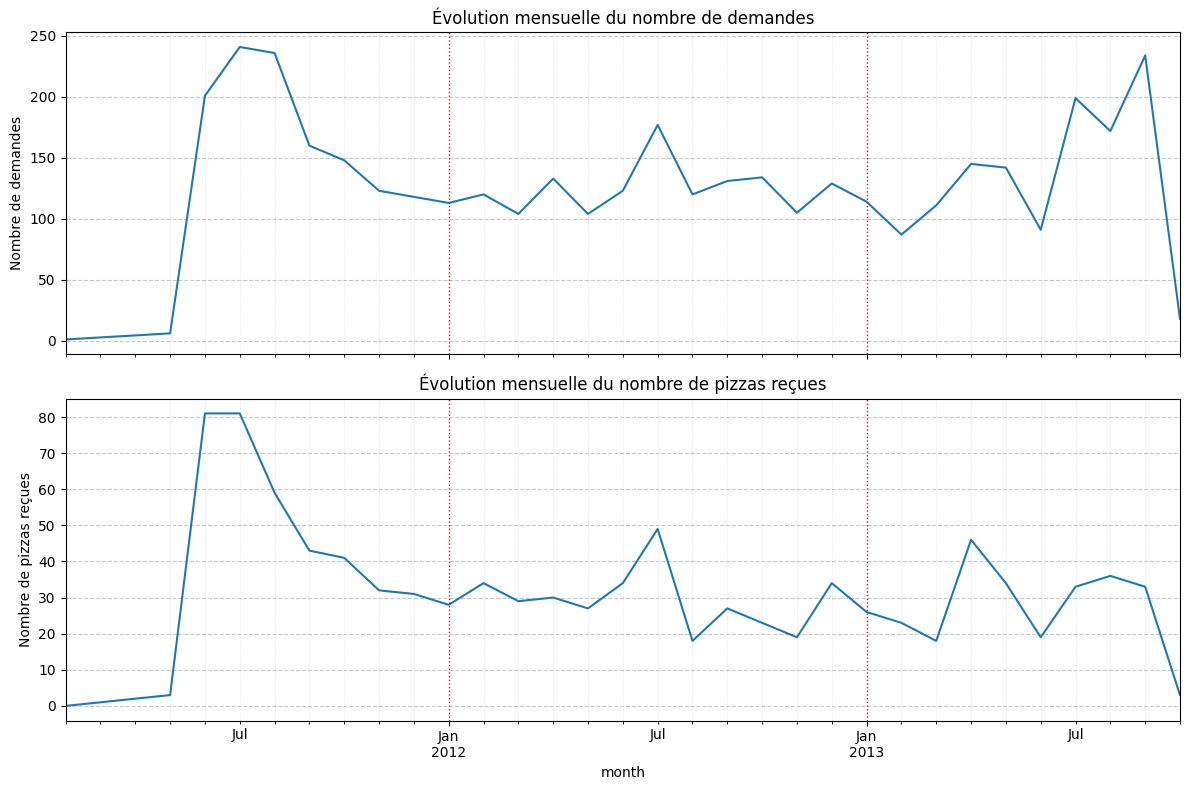

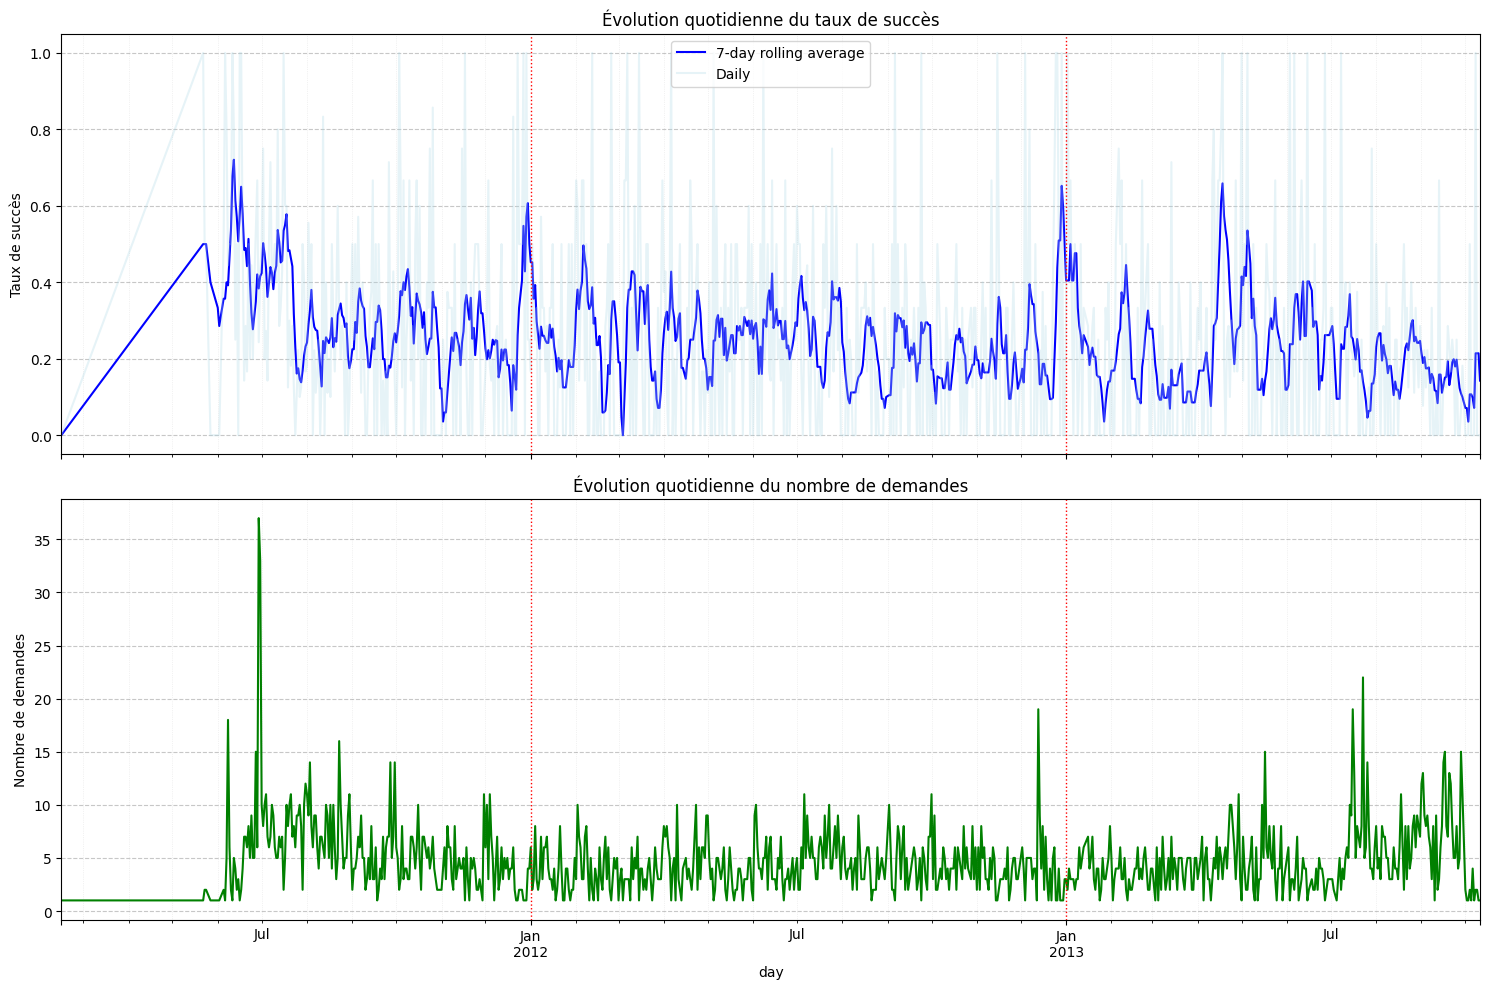

Correlation between number of requests and pizzas received: 0.84
Overall success rate: 24.60%
Data spans from 2011-02-14 to 2013-10-11
Daily correlation between requests and pizzas received: 0.60
Mean requests per day: 4.8
Median requests per day: 4.0
Days with fewer than 5 requests: 453 out of 844


In [25]:
df["month"] = pd.to_datetime(df["request_time_utc"]).dt.to_period("M")

# Convert request timestamps to daily periods for day-by-day analysis
df["day"] = pd.to_datetime(df["request_time_utc"]).dt.to_period("D")

# Calculate monthly success rates
monthly_success = (
    df.groupby("month")["requester_received_pizza"]
    .mean()
    .rename("success_rate")
)

# Calculate daily success rates
daily_success = (
    df.groupby("day")["requester_received_pizza"]
    .mean()
    .rename("success_rate")
)

# 7 day moving average to smooth the plot
daily_success_smoothed = daily_success.rolling(window=7, min_periods=1).mean()

#Success rate by month
fig, ax = plt.subplots(figsize=(10, 4))
monthly_success.plot(ax=ax)


years = monthly_success.index.year.unique()
for year in years[1:]:
    ax.axvline(pd.Period(f"{year}-01"), color='red', linestyle=':', linewidth=1)


for period in monthly_success.index[1:]:
    if period.month == 1:
        continue
    ax.axvline(period, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

ax.set_ylabel("Taux de succès")
ax.set_title("Évolution mensuelle du taux de succès")
plt.show()

# Create a DataFrame with counts per month
monthly_counts = df.groupby("month").agg(
    total_requests=("requester_received_pizza", "count"),
    pizzas_received=("requester_received_pizza", "sum")
)

#Requests and pizza counts by month
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

monthly_counts["total_requests"].plot(ax=axes[0])
axes[0].set_ylabel("Nombre de demandes")
axes[0].set_title("Évolution mensuelle du nombre de demandes")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

monthly_counts["pizzas_received"].plot(ax=axes[1])
axes[1].set_ylabel("Nombre de pizzas reçues")
axes[1].set_title("Évolution mensuelle du nombre de pizzas reçues")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add vertical dotted lines for years 
for year in years[1:]:
    for ax in axes:
        ax.axvline(pd.Period(f"{year}-01"), color='red', linestyle=':', linewidth=1)

for period in monthly_counts.index[1:]:
    if period.month == 1:
        continue  
    for ax in axes:
        ax.axvline(period, color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a DataFrame with counts per day
daily_counts = df.groupby("day").agg(
    total_requests=("requester_received_pizza", "count"),
    pizzas_received=("requester_received_pizza", "sum")
)

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

daily_success_smoothed.plot(ax=axes[0], color='blue', label='7-day rolling average')
daily_success.plot(ax=axes[0], color='lightblue', alpha=0.3, label='Daily')
axes[0].set_ylabel("Taux de succès")
axes[0].set_title("Évolution quotidienne du taux de succès")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend()

daily_counts["total_requests"].plot(ax=axes[1], color='green')
axes[1].set_ylabel("Nombre de demandes")
axes[1].set_title("Évolution quotidienne du nombre de demandes")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

for year in years[1:]:
    for ax in axes:
        ax.axvline(pd.Period(f"{year}-01-01"), color='red', linestyle=':', linewidth=1)

for year in years:
    for month in range(2, 13): 
        for ax in axes:
            ax.axvline(pd.Period(f"{year}-{month:02d}-01"), color='gray', linestyle=':', linewidth=0.5, alpha=0.2)

plt.tight_layout()
plt.show()

# Calculate correlation and overall statistics
correlation = monthly_counts["total_requests"].corr(monthly_counts["pizzas_received"])
print(f"Correlation between number of requests and pizzas received: {correlation:.2f}")

total_requests = monthly_counts["total_requests"].sum()
total_received = monthly_counts["pizzas_received"].sum()
overall_success_rate = total_received / total_requests
print(f"Overall success rate: {overall_success_rate:.2%}")

# Print date range information
first_date = pd.to_datetime(df["request_time_utc"]).min()
last_date = pd.to_datetime(df["request_time_utc"]).max()
print(f"Data spans from {first_date.date()} to {last_date.date()}")

# Display daily statistics
requests_per_day = daily_counts["total_requests"]
print(f"Daily correlation between requests and pizzas received: {daily_counts['total_requests'].corr(daily_counts['pizzas_received']):.2f}")
print(f"Mean requests per day: {requests_per_day.mean():.1f}")
print(f"Median requests per day: {requests_per_day.median()}")
print(f"Days with fewer than 5 requests: {(requests_per_day < 5).sum()} out of {len(requests_per_day)}")

I see seasonality (annual ?) peak at the month of march/july, anniversary maybe ?


##### User activity


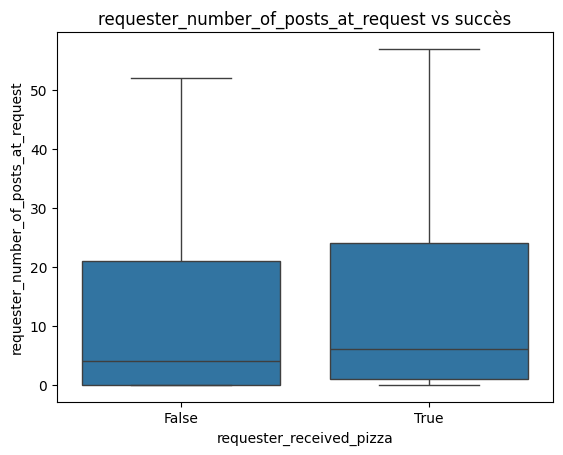

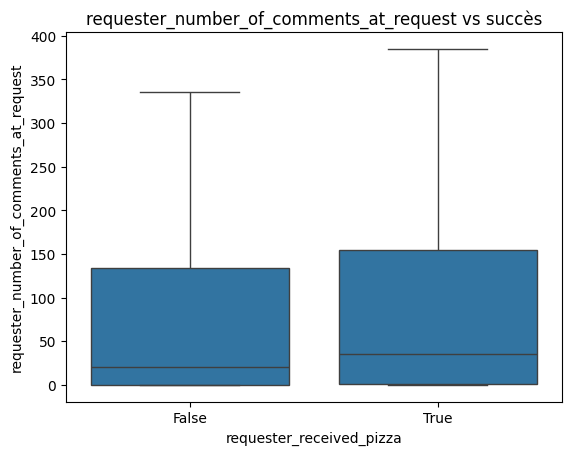

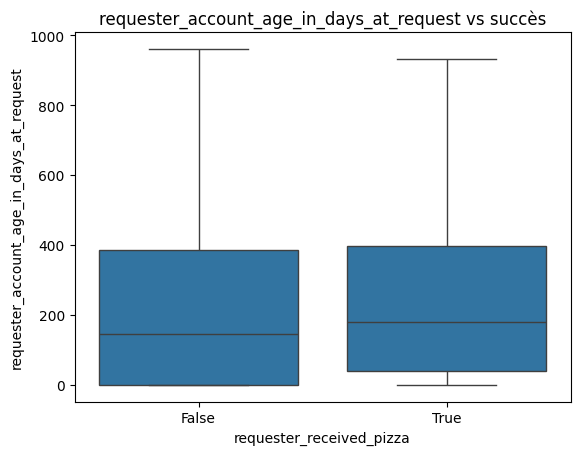

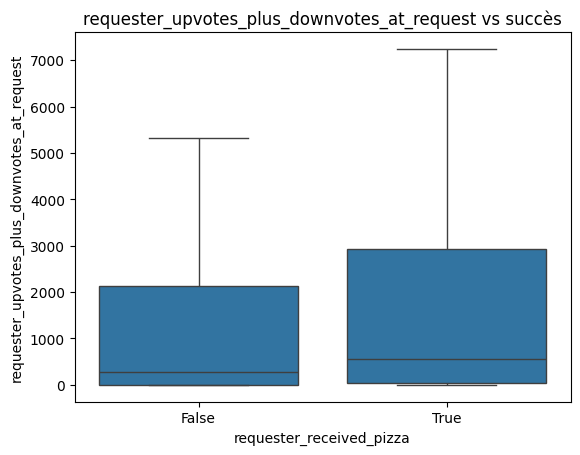

requester_account_age_in_days_at_request       0.041784
requester_number_of_comments_at_request        0.033779
requester_upvotes_plus_downvotes_at_request    0.026102
requester_number_of_posts_at_request           0.020612
dtype: float64

In [26]:
activity_cols = [
    "requester_number_of_posts_at_request",
    "requester_number_of_comments_at_request",
    "requester_account_age_in_days_at_request",
    "requester_upvotes_plus_downvotes_at_request",
]

# Boxplots par statut
for col in activity_cols:
    sns.boxplot(
        x="requester_received_pizza",
        y=col,
        data=df,
        showfliers=False
    )
    plt.title(f"{col} vs succès")
    plt.show()



corrs = {
    col: pointbiserialr(df[col], df["requester_received_pizza"])[0]
    for col in activity_cols
}
pd.Series(corrs).sort_values(ascending=False)


In [27]:
pd.crosstab(
    df["requester_user_flair"].fillna("None"),
    df["requester_received_pizza"],
    normalize="index"
)


requester_received_pizza,False,True
requester_user_flair,,
None,1.0,0.0
PIF,0.0,1.0
shroom,0.0,1.0


leakage ?


In [28]:
pd.crosstab(
    df["post_was_edited"],
    df["requester_received_pizza"],
    normalize="index"
)


requester_received_pizza,False,True
post_was_edited,,
False,0.779381,0.220619
True,0.620155,0.379845


##### Top reddit X succes rates 

In [29]:


df["requester_subreddits_at_request"] = df["requester_subreddits_at_request"].apply(
    literal_eval
)

subs_counter = Counter(
    sub for joins in df["requester_subreddits_at_request"] for sub in joins
)
top_subs = [s for s, _ in subs_counter.most_common(20)]

sub_success = []
for s in top_subs:
    mask = df["requester_subreddits_at_request"].apply(lambda lst: s in lst)
    rate = df.loc[mask, "requester_received_pizza"].mean()
    sub_success.append({"subreddit": s, "success_rate": rate, "count": mask.sum()})

pd.DataFrame(sub_success).sort_values("success_rate", ascending=False).head(10)


,subreddit,success_rate,count
11,reddit.com,0.312910,914
13,fffffffuuuuuuuuuuuu,0.296339,874
6,Random_Acts_Of_Pizza,0.290870,1413
1,pics,0.277578,1949
0,AskReddit,0.275249,2307
4,IAmA,0.274054,1507
2,funny,0.273810,1932
8,todayilearned,0.272892,1103
3,WTF,0.272607,1515
7,videos,0.272414,1160


Top 3 Subreddits with Most Requests by Month


,month,rank,subreddit,success_rate,count
0,2011-02,1,AdviceAnimals,0.000000,1
1,2011-02,2,AskReddit,0.000000,1
2,2011-02,3,Assistance,0.000000,1
3,2011-05,1,AskReddit,0.500000,2
4,2011-05,2,IAmA,0.500000,2
...,...,...,...,...,...
88,2013-09,2,funny,0.142857,161
89,2013-09,3,pics,0.155280,161
90,2013-10,1,Random_Acts_Of_Pizza,0.176471,17
91,2013-10,2,AskReddit,0.187500,16


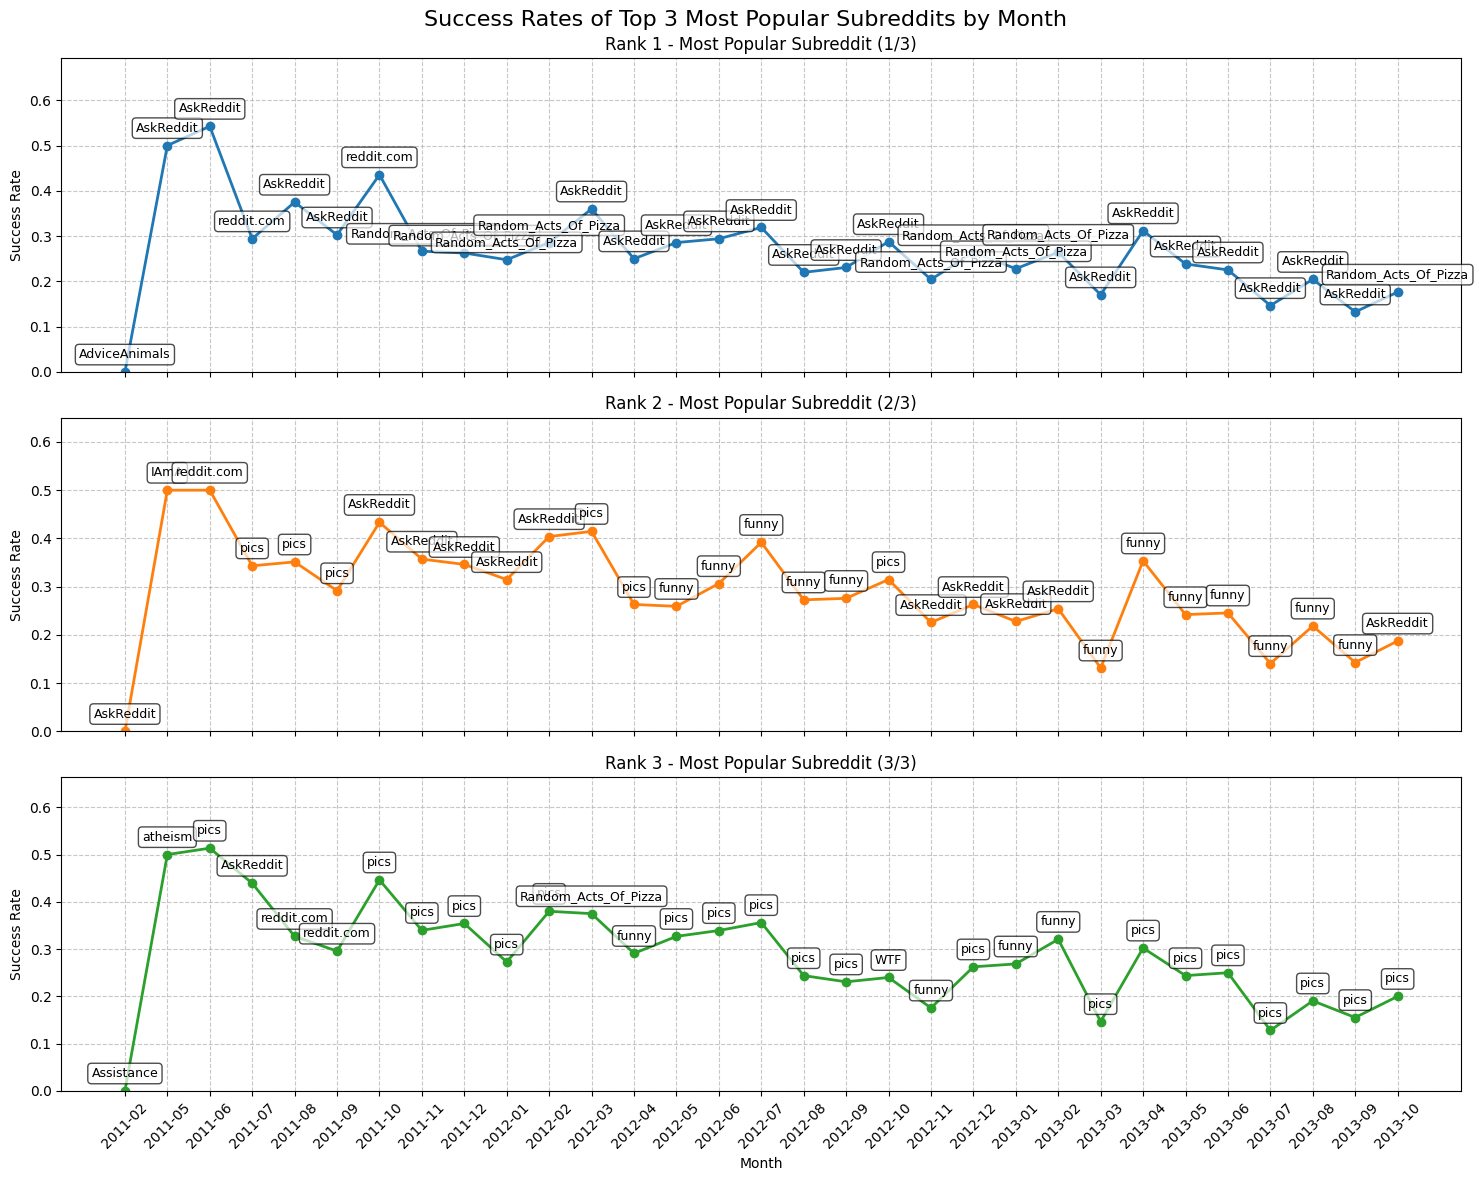

In [30]:

if "month" not in df.columns:
    df["month"] = pd.to_datetime(df["request_time_utc"]).dt.to_period("M")

# Number of top subreddits to track each month
TOP_N = 3

# Get top subreddits by request count for each month
monthly_top3 = []

for month in sorted(df["month"].unique()):
    # Filter data by month
    month_df = df[df["month"] == month]
    
    # Count requests for all subreddits=
    sub_counts = {}
    for sub_list in month_df["requester_subreddits_at_request"]:
        for sub in sub_list:
            sub_counts[sub] = sub_counts.get(sub, 0) + 1
    
    # Get top N subreddits by request count
    if sub_counts:
        top_subs = sorted(sub_counts.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
        
        # Calculate success rate for each top subreddit
        for i, (sub, count) in enumerate(top_subs):
            mask = month_df["requester_subreddits_at_request"].apply(lambda lst: sub in lst)
            success_rate = month_df.loc[mask, "requester_received_pizza"].mean()
            
            monthly_top3.append({
                "month": month,
                "rank": i + 1,
                "subreddit": sub,
                "success_rate": success_rate,
                "count": count
            })

# Convert to DataFrame
monthly_top3_df = pd.DataFrame(monthly_top3)

# Display the results
print(f"Top {TOP_N} Subreddits with Most Requests by Month")
display(monthly_top3_df)

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, rank in enumerate([1, 2, 3]):
    ax = axes[i]
    rank_data = monthly_top3_df[monthly_top3_df["rank"] == rank]
    
    ax.plot(rank_data["month"].astype(str), rank_data["success_rate"], 
            marker='o', color=colors[i], linewidth=2)
    
    for idx, row in rank_data.iterrows():
        ax.annotate(row["subreddit"], 
                   (str(row["month"]), row["success_rate"]),
                   xytext=(0, 10), 
                   textcoords='offset points',
                   ha='center', 
                   fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
    
    ax.set_title(f"Rank {rank} - Most Popular Subreddit ({i+1}/{TOP_N})", fontsize=12)
    ax.set_ylim(0, min(1.0, rank_data["success_rate"].max() + 0.15))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel("Success Rate")

axes[2].set_xlabel("Month")
plt.xticks(rotation=45)

fig.suptitle(f"Success Rates of Top {TOP_N} Most Popular Subreddits by Month", fontsize=16)
plt.tight_layout()
plt.show()

##### Hour ??


In [31]:
df["request_datetime"] = pd.to_datetime(df["request_time_utc"])
df["weekday"] = df["request_datetime"].dt.day_name()
df["hour_utc"] = df["request_datetime"].dt.hour

# Create the pivot table
pivot_hour = pd.pivot_table(
    df,
    values="requester_received_pizza",
    index="weekday",
    columns="hour_utc",
    aggfunc="mean",
)

fig = px.imshow(
    pivot_hour, 
    color_continuous_scale="viridis",
    labels=dict(x="Hour (UTC)", y="Day of Week", color="Success Rate"),
    title="Taux de succès par heure (UTC) et jour de semaine",
    text_auto=".2f" 
)

fig.update_layout(
    xaxis_title="Hour (UTC)",
    yaxis_title="Jour de semaine",
    height=600,
    width=900
)

# Display the figure
fig.show()

# Create pivot table for request counts
pivot_count = pd.pivot_table(
    df,
    values="requester_received_pizza",
    index="weekday",
    columns="hour_utc",
    aggfunc="count",
)

# Create the heatmap
fig = px.imshow(
    pivot_count, 
    color_continuous_scale="plasma",
    labels=dict(x="Hour (UTC)", y="Day of Week", color="Number of Requests"),
    title="Nombre de demandes par heure (UTC) et jour de semaine",
    text_auto=True 
)

# Improve layout
fig.update_layout(
    xaxis_title="Heure (UTC)",
    yaxis_title="Jour de semaine",
    height=600,
    width=900
)

# Display the figure
fig.show()



##### Text lenght X corr


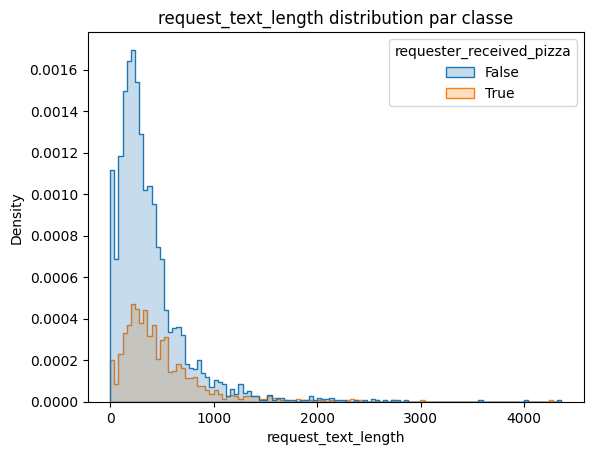

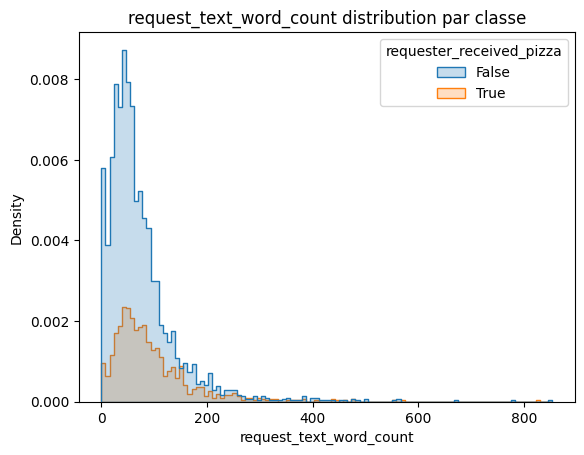

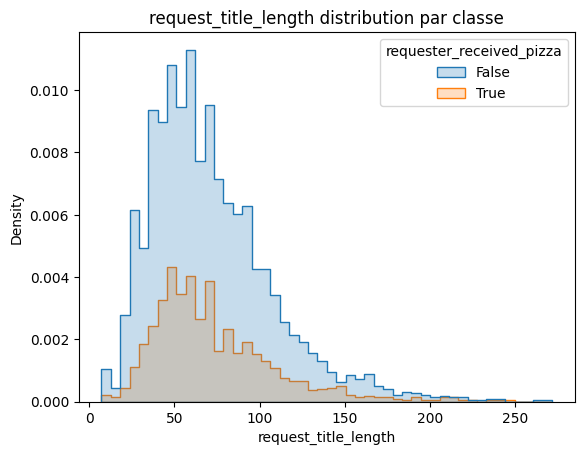

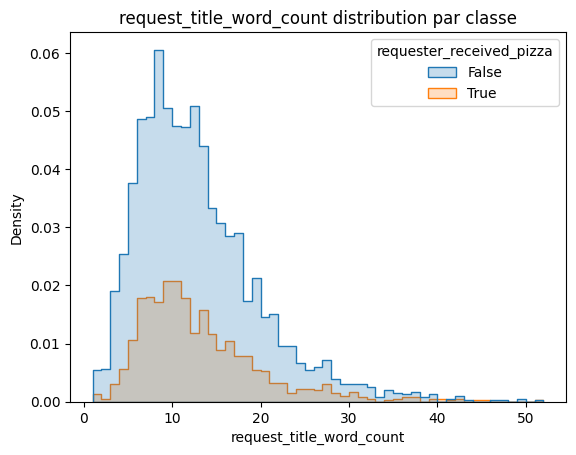

request_text_length         0.124149
request_text_word_count     0.121941
request_title_word_count    0.015680
request_title_length        0.014847
dtype: float64

In [32]:
text_len_cols = [
    "request_text_length",
    "request_text_word_count",
    "request_title_length",
    "request_title_word_count",
]

for col in text_len_cols:
    sns.histplot(data=df, x=col, hue="requester_received_pizza", element="step", stat="density")
    plt.title(f"{col} distribution par classe")
    plt.show()

pd.Series({
    col: pointbiserialr(df[col], df["requester_received_pizza"])[0]
    for col in text_len_cols
}).sort_values(ascending=False)


##### TF IDF 

In [33]:

df["request_text"] = df["request_text"].fillna("")

pos_texts = df.loc[df["requester_received_pizza"], "request_text"].tolist()
neg_texts = df.loc[~df["requester_received_pizza"], "request_text"].tolist()

vectorizer = TfidfVectorizer(min_df=5, stop_words="english")
tfidf = vectorizer.fit_transform(pos_texts + neg_texts)

labels = np.array([1]*len(pos_texts) + [0]*len(neg_texts))
coeffs = tfidf.T @ labels 

top_pos = np.argsort(-coeffs)[:20]
top_neg = np.argsort(coeffs)[:20]

print("Top tokens positifs :")
print([vectorizer.get_feature_names_out()[i] for i in top_pos])

print("\nTop tokens négatifs :")
print([vectorizer.get_feature_names_out()[i] for i in top_neg])


Top tokens positifs :
['pizza', 'just', 'help', 'thanks', 'food', 've', 'really', 'pay', 'money', 'week', 'don', 'like', 'work', 'forward', 'job', 'paid', 'love', 'edit', 'day', 'time']

Top tokens négatifs :
['understanding', 'marriage', 'master', 'twin', 'turkey', 'smoked', 'smoking', 'mcdonalds', 'budgeted', 'apologies', 'memphis', 'fam', 'apply', 'metropolitan', 'transmission', 'essay', 'curious', 'equally', 'pressure', 'mode']


In [ ]:

df["request_text"] = df["request_text"].fillna("")

cv = CountVectorizer(min_df=5, stop_words="english")
X = cv.fit_transform(df["request_text"])
y = df["requester_received_pizza"].astype(int).values

chi2_scores, _ = chi2(X, y)

chi2_df = (
    pd.DataFrame(
        {"token": cv.get_feature_names_out(), "chi2": chi2_scores}
    )
    .sort_values("chi2", ascending=False)
)

display(chi2_df.head(20))   # top termes pro-succès
display(chi2_df.tail(20))   # top termes anti-succès


,token,chi2
788,edit,70.451052
2646,ve,51.126501
618,days,39.857083
2088,rice,37.842622
2494,thanks,35.100185
1798,pay,34.151426
2491,thank,33.786663
1799,paycheck,29.882922
991,forward,28.478824
2713,weeks,26.141762


,token,chi2
2128,sales,0.000676
341,brand,0.000676
217,aunt,0.000676
1607,mn,0.000676
1629,motivation,0.000676
870,express,0.000676
1630,mouth,0.000676
168,applications,0.000676
1563,men,0.000676
869,explains,0.000676


In [ ]:
pos_docs = df.loc[df["requester_received_pizza"], "request_text"].tolist()
neg_docs = df.loc[~df["requester_received_pizza"], "request_text"].tolist()

# word count
def count_tokens(docs):
    cnt = Counter()
    for doc in docs:
        cnt.update(doc.split())
    return cnt

pos_cnt = count_tokens(pos_docs)
neg_cnt = count_tokens(neg_docs)

vocab = set(pos_cnt).union(neg_cnt)
alpha = 1.0 
pos_total = sum(pos_cnt.values()) + alpha * len(vocab)
neg_total = sum(neg_cnt.values()) + alpha * len(vocab)

log_odds = {}
for w in vocab:
    pw = (pos_cnt.get(w, 0) + alpha) / pos_total
    nw = (neg_cnt.get(w, 0) + alpha) / neg_total
    log_odds[w] = np.log(pw / nw)

lod_df = (
    pd.Series(log_odds, name="log_odds")
    .sort_values(ascending=False)
    .to_frame()
)
print("🔼 Tokens pro-succès")
display(lod_df.head(20))

print("🔽 Tokens anti-succès")
display(lod_df.tail(20))


🔼 Tokens pro-succès


,log_odds
cups,2.699371
(by,2.545220
mentioned,2.545220
"beans,",2.545220
fee.,2.362899
**1stgenrex**,2.362899
debts,2.362899
schwab,2.362899
relatives,2.362899
disney,2.362899


🔽 Tokens anti-succès


,log_odds
tests,-1.644434
50,-1.644434
english,-1.644434
go.,-1.644434
understanding,-1.644434
yup,-1.731446
penny,-1.731446
uh,-1.731446
wallet.,-1.731446
love.,-1.731446


###  NLP

In [36]:
TEXT_COLS = ["request_text", "request_text_edit_aware", "request_title"]
df[TEXT_COLS] = df[TEXT_COLS].fillna("")
print(df.shape)

(4040, 45)


##### Sentiment

In [37]:
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

for col in ["request_text_edit_aware"]:
    scores = df[col].apply(sia.polarity_scores).apply(pd.Series)
    df[[f"{col}_sent_pos", f"{col}_sent_neg", f"{col}_sent_neu", f"{col}_sent_comp"]] = scores[
        ["pos", "neg", "neu", "compound"]
    ]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mzouicha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


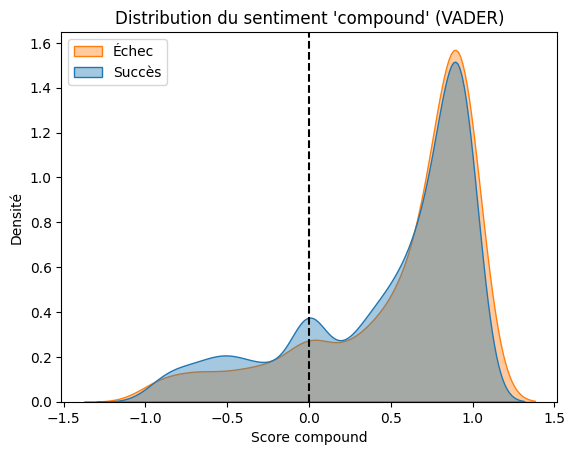

In [38]:


sns.kdeplot(
    data=df,
    x="request_text_edit_aware_sent_comp",
    hue="requester_received_pizza",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.axvline(0, color="black", ls="--")
plt.title("Distribution du sentiment 'compound' (VADER)")
plt.xlabel("Score compound")
plt.ylabel("Densité")
plt.legend(labels=["Échec", "Succès"])
plt.show()


C:\Users\mzouicha\AppData\Local\Temp\ipykernel_14124\2111570559.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



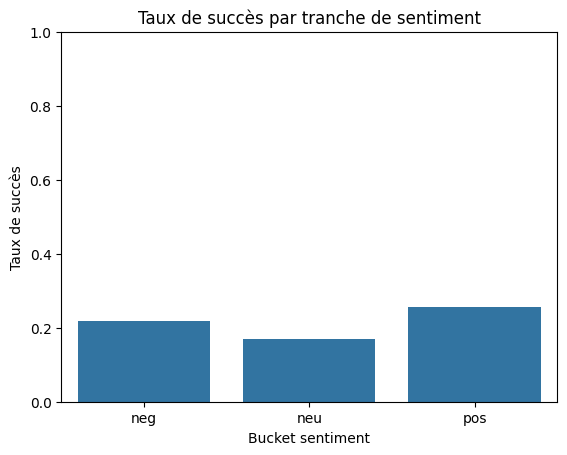

In [39]:
# Règles VADER : neg < −0.05, neu ∈ [−0.05, 0.05], pos > 0.05
bins = [-1, -0.05, 0.05, 1]
labels = ["neg", "neu", "pos"]
df["sent_bucket"] = pd.cut(df["request_text_edit_aware_sent_comp"], bins=bins, labels=labels)

bucket_success = (
    df.groupby("sent_bucket")["requester_received_pizza"]
    .mean()
    .rename("success_rate")
    .reset_index()
)

sns.barplot(data=bucket_success, x="sent_bucket", y="success_rate")
plt.title("Taux de succès par tranche de sentiment")
plt.ylabel("Taux de succès")
plt.xlabel("Bucket sentiment")
plt.ylim(0, 1)
plt.show()


In [40]:

sent_cols = [
    "request_text_edit_aware_sent_pos",
    "request_text_edit_aware_sent_neg",
    "request_text_edit_aware_sent_neu",
    "request_text_edit_aware_sent_comp",
]

corrs = {
    col: pointbiserialr(df[col], df["requester_received_pizza"])[0]
    for col in sent_cols
}

pd.Series(corrs, name="pointbiserial_corr").sort_values(ascending=False)


request_text_edit_aware_sent_comp    0.056306
request_text_edit_aware_sent_neu     0.038190
request_text_edit_aware_sent_pos    -0.010003
request_text_edit_aware_sent_neg    -0.029258
Name: pointbiserial_corr, dtype: float64

V3

In [42]:
import nltk, re, string, math
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm

# ressources
nltk.download("punkt"); nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet"); nltk.download("stopwords")

stop_en   = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def wn_pos(tag):
    return {"N": wordnet.NOUN, "J": wordnet.ADJ}.get(tag[0], wordnet.NOUN)

def tok_noun_adj(text: str):
    text = re.sub(r"http\S+|www\S+", "", text.lower())
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(tok, pos=wn_pos(tag))
        for tok, tag in tagged
        if tag[0] in {"N", "J"} 
        and tok.isalpha()         
        and tok not in stop_en
        and len(tok) > 2
    ]
    return lemmas

tqdm.pandas()
df["tokens"] = (df["request_title"] + " " + df["request_text_edit_aware"]).progress_apply(tok_noun_adj)


c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mzouicha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mzouicha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mzouicha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mzouicha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 4040/4040 [00:12<00:00, 316.96it/s]


In [ ]:
BIGRAM_MIN   = 20   
TRIGRAM_MIN  = 10
SEP          = "_"   

# bigrams
sentences = df["tokens"].tolist()    
bigram_cnt = Counter()
for toks in sentences:
    bigram_cnt.update(zip(toks, toks[1:]))
bigram_set = {bg for bg, c in bigram_cnt.items() if c >= BIGRAM_MIN}
def merge_bigrams(tokens):
    merged = []
    i = 0
    while i < len(tokens):
        if i < len(tokens) - 1 and (tokens[i], tokens[i+1]) in bigram_set:
            merged.append(tokens[i] + SEP + tokens[i+1])
            i += 2
        else:
            merged.append(tokens[i])
            i += 1
    return merged

tokens_big = [merge_bigrams(toks) for toks in sentences]

#Trigrams
trigram_cnt = Counter()
for toks in tokens_big:
    trigram_cnt.update(zip(toks, toks[1:], toks[2:]))

trigram_set = {tg for tg, c in trigram_cnt.items() if c >= TRIGRAM_MIN}

def merge_trigrams(tokens):
    merged = []
    i = 0
    while i < len(tokens):
        if i < len(tokens) - 2 and (tokens[i], tokens[i+1], tokens[i+2]) in trigram_set:
            merged.append(tokens[i] + SEP + tokens[i+1] + SEP + tokens[i+2])
            i += 3
        else:
            merged.append(tokens[i])
            i += 1
    return merged

df["tokens_phr"] = sentences = [merge_trigrams(toks) for toks in tokens_big]

print("Bigrammes fusionnés :", len(bigram_set), "| Trigrammes fusionnés :", len(trigram_set))


Bigrammes fusionnés : 267 | Trigrammes fusionnés : 0


In [ ]:
freq = Counter(tok for doc in sentences for tok in doc)
total_docs = len(sentences)
doc_freq = Counter(tok for doc in sentences for tok in set(doc))
cutoff = np.percentile(list(doc_freq.values()), 99)      # top 1 %
ban_set = {tok for tok, dfreq in doc_freq.items() if dfreq >= cutoff}

def drop_top1(doc):
    return [tok for tok in doc if tok not in ban_set]

df["tokens_filt"] = df["tokens_phr"].apply(drop_top1)


In [ ]:

tfidf_vec = TfidfVectorizer(
    tokenizer=lambda x: x, preprocessor=lambda x: x,
    lowercase=False, ngram_range=(1,1),
    min_df=5, max_df=0.6
)
tfidf_mat = tfidf_vec.fit_transform(df["tokens_filt"])
vocab = np.array(tfidf_vec.get_feature_names_out())
print(tfidf_mat.shape)


(4040, 2051)


c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [ ]:
docs_tokens = df["tokens_filt"].tolist()
doc_freq = Counter(tok for doc in docs_tokens for tok in set(doc))
N_DOCS = len(docs_tokens)

def p_w(w):
    return (doc_freq[w] + 1) / N_DOCS     

def p_w1w2(w1, w2):
    co = sum(1 for doc in docs_tokens if w1 in doc and w2 in doc)
    return (co + 1) / N_DOCS      

# PMI
def coherence_pmi(top_terms):
    pairs = list(combinations(top_terms, 2))
    pmi_vals = [
        math.log(p_w1w2(w1, w2) / (p_w(w1) * p_w(w2)))
        for w1, w2 in pairs
    ]
    return np.mean(pmi_vals)


def evaluate_k(k, top_n=10):
    nmf = NMF(n_components=k, random_state=42, init="nndsvd")
    W = nmf.fit_transform(tfidf_mat)
    H = nmf.components_
    scores = []
    for comp in H:
        terms = vocab[comp.argsort()[:-top_n-1:-1]]
        scores.append(coherence_pmi(terms))
    return nmf, W, H, np.mean(scores)

scores = {}
models = {}
for k in range(6, 13):        # k = 6 … 12
    nmf, Wk, Hk, coh = evaluate_k(k)
    scores[k] = coh
    models[k] = (nmf, Wk, Hk)
    print(f"k={k:2d}  cohérence_PMI={coh:.4f}")

#best_k = max(scores, key=scores.get)
best_k = 8
nmf, W, H = models[best_k]
print(f"\n✅ meilleur k = {best_k} (cohérence {scores[best_k]:.4f})")


KeyError: 'tokens_filt'

Topic 00: lunch | post | hey | redditor | subreddit | grateful | rice | name | couple | everyone | moment | someone_pizza
Topic 01: birthday | request_birthday | party | boyfriend | gift | present | daughter | best_friend | proof | crust | class | bday
Topic 02: final | college_student | request_usa | project | semester | request_student | university | class | pizza_tonight | exam | request_college | summer
Topic 03: wife | son | baby | year_old | husband | daughter | amp | pregnant | tight | boy | anniversary | food_stamp
Topic 04: sick | cold | soup | canada | dog | pizza_hut | pasta | noodle | poor | energy | domino | bed
Topic 05: mom | sister | dad | parent | daughter | boyfriend | mother | amp | year_old | hospital | dog | father
Topic 06: sob_story | poor | free_pizza | north | lol | real | heart | carolina | get | luck | fun | hungover
Topic 07: check | monday | bank | till | next | unemployment | new_job | grocery | wednesday | get | tuesday | low
Topic 08: payday | thursday |

C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\408441375.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




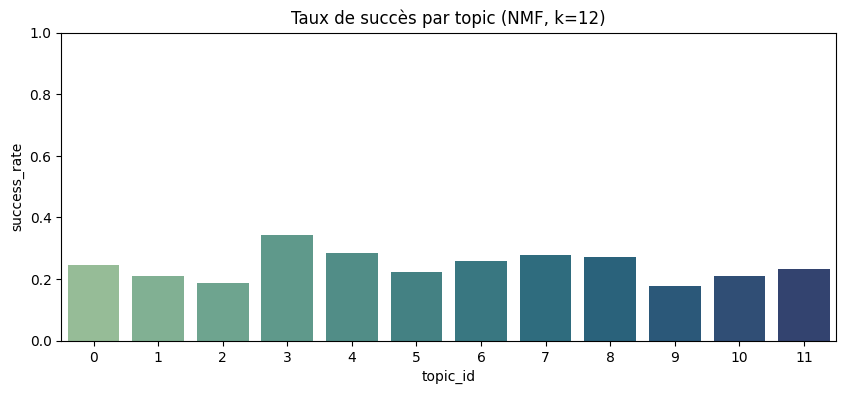

,topic_id,success_rate
3,3,0.342222
4,4,0.285714
7,7,0.278481
8,8,0.272727
6,6,0.258741
0,0,0.245749
11,11,0.231884
5,5,0.223140
10,10,0.211180
1,1,0.208696


In [ ]:
def show_nmf_topics(H, vocab, n_terms=12, ban="pizza"):
    for idx, comp in enumerate(H):
        terms = [vocab[i] for i in comp.argsort()[:-n_terms-1:-1] if vocab[i] != ban][:n_terms]
        print(f"Topic {idx:02d}: {' | '.join(terms)}")

show_nmf_topics(H, vocab)

df["topic_id"]       = W.argmax(axis=1)
df["topic_dom_prob"] = W.max(axis=1)

topic_success = (
    df.groupby("topic_id")["requester_received_pizza"]
      .mean()
      .rename("success_rate")
      .reset_index()
      .sort_values("success_rate", ascending=False)
)

plt.figure(figsize=(10,4))
sns.barplot(data=topic_success, x="topic_id", y="success_rate", palette="crest")
plt.ylim(0,1)
plt.title(f"Taux de succès par topic (NMF, k={best_k})")
plt.show()

topic_success


In [ ]:
print("Summary\n")

# Data overview
print("Overview")
print(f"Shape of DataFrame: {df.shape}")
print("Sample rows:")
display(df.head(3))
print("\nMissing values (top 10 columns):")
missing = df.isna().mean().sort_values(ascending=False).head(10)
display(missing)

# Target distribution
print("\n[Target Distribution]")
target_rate = df["requester_received_pizza"].mean()
print(f"prevalence: {target_rate:.2%}")
print("Refer to the countplot for a visual distribution.")

# Temporal trends & aggregated stats
print("\n[Temporal Trends & Aggregated Statistics]")
first_date = pd.to_datetime(df["request_time_utc"]).min().date()
last_date = pd.to_datetime(df["request_time_utc"]).max().date()
print(f"Data spans from {first_date} to {last_date}")
print("Monthly evolution and success rates were plotted.")
print(f"Correlation between total requests and pizzas received: {correlation:.2f}")

# User activity insights
print("\n[User Activity]")
print("Features examined:", ", ".join(activity_cols))
print("Boxplots and point-biserial correlations have been computed for these features.")

# Text analysis insights
print("\n[Text Analysis]")
print("TF-IDF was used to extract top positive and negative tokens (see earlier plots).")

# Chi² Analysis for Words
print("\n[Chi² Analysis for Words]")
print("Top Chi² terms (pro-success):")
display(chi2_df.head(20))
print("Bottom Chi² terms (anti-success):")
display(chi2_df.tail(20))

# Log Odds Analysis for Terms (Up/Down Scores)
print("\n[Log Odds Analysis for Terms]")
print("Tokens with highest log odds (pro-success):")
display(lod_df.head(20))
print("Tokens with lowest log odds (anti-success):")
display(lod_df.tail(20))

# Sentiment analysis summary
print("\n[Sentiment Analysis]")
print("VADER 'compound' score summary:")
display(df["request_text_edit_aware_sent_comp"].describe())
print("Success rates by sentiment bucket:")
display(bucket_success)

# Topic modeling (NMF)
print("\n[Topic Modeling (NMF)]")
print(f"A Non-negative Matrix Factorization (NMF) model with k = {best_k} topics was evaluated.")
print("Topic success rates:")
display(topic_success)


########### FULL INSIGHTS SUMMARY ###########

[Data Overview]
Shape of DataFrame: (4040, 56)
Sample rows:


,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,request_text_edit_aware_sent_comp,sent_bucket,topic_id,topic_dom_prob,tokens_nouns,tokens_clean,tokens,text_clean,tokens_phr,tokens_filt
0,NaN,0,1,False,t3_l25d7,0,hi i am in need of food for my 4 children we a...,hi i am in need of food for my 4 children we a...,request colorado springs help us please,0.0000,...,0.8323,pos,0,0.022192,"[request, colorado, spring, need, food, child,...","[request, colorado, spring, help, please, need...","[request, colorado, spring, need, food, child,...",request colorado spring need food child milita...,"[request, colorado, spring, need_food, child, ...","[colorado, spring, need_food, child, military,..."
1,NaN,2,5,False,t3_rcb83,0,i spent the last money i had on gas today. im ...,i spent the last money i had on gas today. im ...,"[request] california, no cash and i could use ...",501.1111,...,-0.6908,neg,8,0.134641,"[request, california, cash, dinner, money, gas...","[request, california, cash, use, dinner, spend...","[request, california, cash, dinner, last, mone...",request california cash dinner last money gas ...,"[request_california, cash, dinner, last_money,...","[request_california, last_money, gas, next, th..."
2,NaN,0,3,False,t3_lpu5j,0,my girlfriend decided it would be a good idea ...,my girlfriend decided it would be a good idea ...,"[request] hungry couple in dundee, scotland wo...",0.0000,...,0.8074,pos,9,0.153578,"[request, couple, dundee, scotland, pizza, gir...","[request, hungry, couple, dundee, scotland, lo...","[request, hungry, couple, dundee, scotland, pi...",request hungry couple dundee scotland pizza gi...,"[request_hungry, couple, dundee, scotland, piz...","[couple, dundee, scotland, girlfriend, idea, p..."



Missing values (top 10 columns):


giver_username_if_known                      0.928960
requester_user_flair                         0.753960
request_text_original                        0.025743
request_text_edit_aware_original             0.025743
number_of_upvotes_of_request_at_retrieval    0.000000
weekday                                      0.000000
request_title_original                       0.000000
request_text_length                          0.000000
request_text_word_count                      0.000000
request_text_edit_aware_length               0.000000
dtype: float64


[Target Distribution]
Overall success prevalence: 24.60%
Refer to the countplot for a visual distribution.

[Temporal Trends & Aggregated Statistics]
Data spans from 2011-02-14 to 2013-10-11
Monthly evolution and success rates were plotted.
Correlation between total requests and pizzas received: 0.84

[User Activity]
Features examined: requester_number_of_posts_at_request, requester_number_of_comments_at_request, requester_account_age_in_days_at_request, requester_upvotes_plus_downvotes_at_request
Boxplots and point-biserial correlations have been computed for these features.

[Text Analysis]
TF-IDF was used to extract top positive and negative tokens (see earlier plots).

[Chi² Analysis for Words]
Top Chi² terms (pro-success):


,token,chi2
788,edit,70.451052
2646,ve,51.126501
618,days,39.857083
2088,rice,37.842622
2494,thanks,35.100185
1798,pay,34.151426
2491,thank,33.786663
1799,paycheck,29.882922
991,forward,28.478824
2713,weeks,26.141762


Bottom Chi² terms (anti-success):


,token,chi2
2128,sales,0.000676
341,brand,0.000676
217,aunt,0.000676
1607,mn,0.000676
1629,motivation,0.000676
870,express,0.000676
1630,mouth,0.000676
168,applications,0.000676
1563,men,0.000676
869,explains,0.000676



[Log Odds Analysis for Terms]
Tokens with highest log odds (pro-success):


,log_odds
cups,2.699371
(by,2.545220
mentioned,2.545220
"beans,",2.545220
warrant,2.362899
much!!,2.362899
fee.,2.362899
**1stgenrex**,2.362899
relatives,2.362899
schwab,2.362899


Tokens with lowest log odds (anti-success):


,log_odds
tests,-1.644434
english,-1.644434
bless.,-1.644434
phone.,-1.644434
understanding,-1.644434
penny,-1.731446
wallet.,-1.731446
yup,-1.731446
uh,-1.731446
love.,-1.731446



[Sentiment Analysis]
VADER 'compound' score summary:


count    4040.000000
mean        0.500715
std         0.521302
min        -0.993400
25%         0.202300
50%         0.724300
75%         0.908025
max         0.997800
Name: request_text_edit_aware_sent_comp, dtype: float64

Success rates by sentiment bucket:


,sent_bucket,success_rate
0,neg,0.219396
1,neu,0.169884
2,pos,0.257614



[Topic Modeling (NMF)]
A Non-negative Matrix Factorization (NMF) model with k = 12 topics was evaluated.
Topic success rates:


,topic_id,success_rate
3,3,0.342222
4,4,0.285714
7,7,0.278481
8,8,0.272727
6,6,0.258741
0,0,0.245749
11,11,0.231884
5,5,0.223140
10,10,0.211180
1,1,0.208696



########### END OF FULL INSIGHTS ###########



### Covariates EDA



post_was_edited  –  χ² p-value = 0.0000


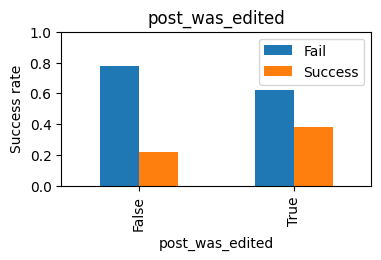

In [ ]:
cat_cols = [
    "post_was_edited",
]

for col in cat_cols:
    ctab = pd.crosstab(df[col].fillna("NA"), df["requester_received_pizza"])
    chi2, p, _, _ = chi2_contingency(ctab)
    print(f"\n{col}  –  χ² p-value = {p:.4f}")
    (ctab.T / ctab.sum(axis=1)).T.plot(kind="bar", stacked=False,
                                       ylabel="Success rate", figsize=(4,2))
    plt.title(col); plt.ylim(0,1); plt.legend(["Fail","Success"]); plt.show()


In [ ]:

# numeric columns not analysed earlier
skip = set(activity_cols + text_len_cols)
num_cols_extra = [c for c,d in df.dtypes.items()
                  if d in ("int64","float32","float64")
                  and c not in skip
                  and c not in ["requester_received_pizza"]]

corrs = {
    col: pointbiserialr(df[col], df["requester_received_pizza"])[0]
    for col in num_cols_extra
    if df[col].nunique() > 8          # ignore near-constant
}

pd.Series(corrs).sort_values(key=abs, ascending=False).head(15)


requester_number_of_posts_on_raop_at_retrieval          0.460637
request_number_of_comments_at_retrieval                 0.289153
requester_number_of_comments_in_raop_at_retrieval       0.274253
requester_number_of_comments_in_raop_at_request         0.131296
requester_days_since_first_post_on_raop_at_retrieval    0.129283
requester_account_age_in_days_at_retrieval              0.120919
request_text_edit_aware_length                          0.114810
request_text_edit_aware_word_count                      0.113304
requester_number_of_comments_at_retrieval               0.105217
number_of_upvotes_of_request_at_retrieval               0.102138
requester_days_since_first_post_on_raop_at_request      0.098225
requester_upvotes_minus_downvotes_at_retrieval          0.077728
request_text_edit_aware_sent_comp                       0.056306
requester_number_of_posts_at_retrieval                  0.048353
requester_upvotes_plus_downvotes_at_retrieval           0.045994
dtype: float64

C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\2834048494.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



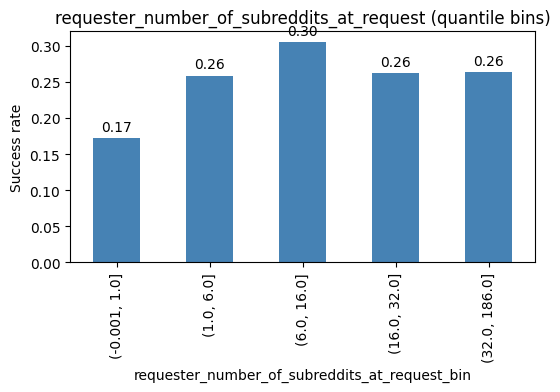

C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\2834048494.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Bin sizes:
 requester_number_of_subreddits_at_request_bin
(-0.001, 1.0]    1091
(1.0, 6.0]        545
(6.0, 16.0]       794
(16.0, 32.0]      832
(32.0, 186.0]     778
Name: count, dtype: int64


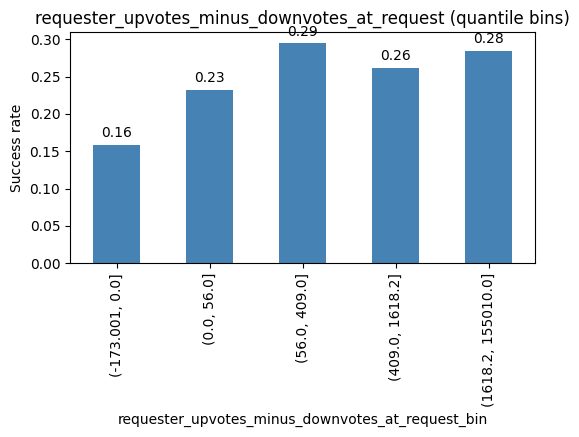

Bin sizes:
 requester_upvotes_minus_downvotes_at_request_bin
(-173.001, 0.0]       814
(0.0, 56.0]           806
(56.0, 409.0]         805
(409.0, 1618.2]       807
(1618.2, 155010.0]    808
Name: count, dtype: int64


C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\2834048494.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



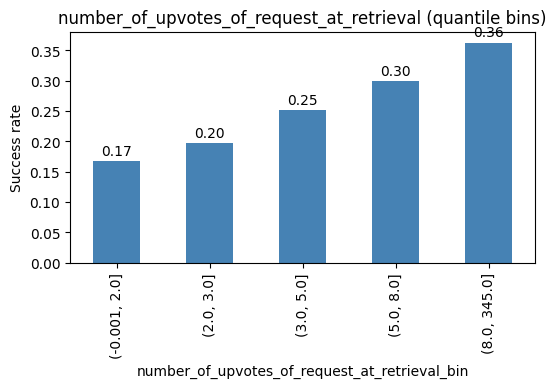

Bin sizes:
 number_of_upvotes_of_request_at_retrieval_bin
(-0.001, 2.0]    1176
(2.0, 3.0]        639
(3.0, 5.0]        857
(5.0, 8.0]        649
(8.0, 345.0]      719
Name: count, dtype: int64


In [ ]:
def plot_binned_rate(col, q=5):
    df[f"{col}_bin"] = pd.qcut(df[col], q, duplicates="drop")
    rate = df.groupby(f"{col}_bin")["requester_received_pizza"].mean()
    count= df[f"{col}_bin"].value_counts().sort_index()
    ax = rate.plot(kind="bar", figsize=(6,3), color="steelblue")
    ax.set_ylabel("Success rate"); ax.set_title(f"{col} (quantile bins)")
    for i,v in enumerate(rate):
        ax.text(i, v+0.01, f"{v:.2f}", ha="center")
    plt.show()
    print("Bin sizes:\n", count)

# examples you didn’t visualise:
for col in ["requester_number_of_subreddits_at_request",
            "requester_upvotes_minus_downvotes_at_request",
            "number_of_upvotes_of_request_at_retrieval"]:
    plot_binned_rate(col)


In [ ]:


num_cols = [c for c in df.select_dtypes(include="number").columns
            if c != "requester_received_pizza"]

def is_list_col(col):
    return df[col].dropna().apply(lambda x: isinstance(x, list)).any()

cat_cols = [c for c in df.select_dtypes(exclude="number").columns
            if c not in TEXT_COLS
            and c != "requester_received_pizza"
            and not is_list_col(c)]

df_mi = pd.DataFrame(index=df.index)
df_mi[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_df = (df[cat_cols]
          .apply(lambda col: col.astype("object"))   # évite l’erreur Categorical
          .fillna("NA"))

enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_mi[cat_cols] = enc.fit_transform(cat_df)

X = df_mi.values
y = df["requester_received_pizza"].values
disc_flags = [False]*len(num_cols) + [True]*len(cat_cols)

mi = mutual_info_classif(X, y,
                         discrete_features=disc_flags,
                         random_state=42)

mi_series = pd.Series(mi, index=num_cols + cat_cols).sort_values(ascending=False)
display(mi_series.head(20))


C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\4294060128.py:24: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:49: UserWarning:

The number of unique classes is greater than 50% of the number of samples.

c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:49: UserWarning:

The number of unique classes is greater than 50% of the number of samples.

c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:49: UserWarning:

The number of unique classes is greater than 50% of the

requester_user_flair                                    0.557942
text_clean                                              0.557942
request_id                                              0.557942
requester_username                                      0.557942
request_time_utc                                        0.557599
request_title_original                                  0.556097
request_text_original                                   0.546082
request_text_edit_aware_original                        0.545463
requester_number_of_posts_on_raop_at_retrieval          0.122326
giver_username_if_known                                 0.108447
request_number_of_comments_at_retrieval                 0.089969
requester_number_of_comments_in_raop_at_retrieval       0.077299
requester_number_of_posts_on_raop_at_request            0.023482
requester_upvotes_plus_downvotes_at_retrieval           0.022465
requester_account_age_in_days_at_retrieval              0.018874
requester_upvotes_minus_d

Success rate for requester_upvotes_plus_downvotes_at_request:
                     success_rate
bin                              
(-0.001, 2.0]            0.158220
(2.0, 119.0]             0.237978
(119.0, 797.8]           0.292289
(797.8, 3312.4]          0.259901
(3312.4, 1286864.0]      0.282178
Bin counts:
bin         (-0.001, 2.0]  (2.0, 119.0]  (119.0, 797.8]  (797.8, 3312.4]  \
n_requests            809           811             804              808   

bin         (3312.4, 1286864.0]  
n_requests                  808  


C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\228865018.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



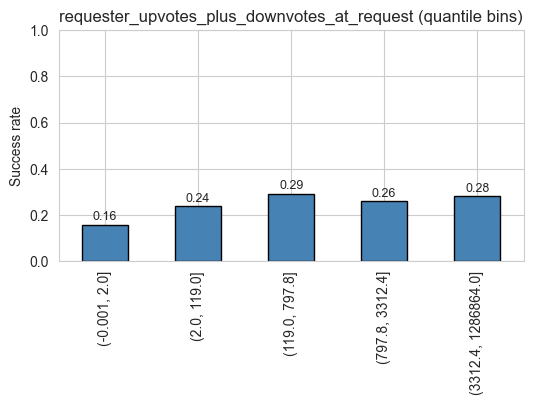

Success rate for requester_upvotes_minus_downvotes_at_request:
                    success_rate
bin                             
(-173.001, 0.0]         0.158477
(0.0, 56.0]             0.232010
(56.0, 409.0]           0.294410
(409.0, 1618.2]         0.261462
(1618.2, 155010.0]      0.284653
Bin counts:
bin         (-173.001, 0.0]  (0.0, 56.0]  (56.0, 409.0]  (409.0, 1618.2]  \
n_requests              814          806            805              807   

bin         (1618.2, 155010.0]  
n_requests                 808  


C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\228865018.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



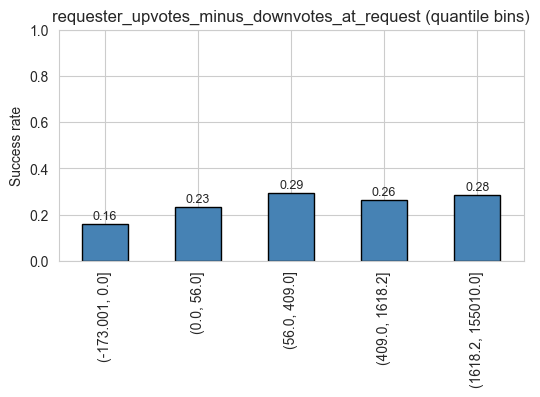

C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\228865018.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Success rate for requester_account_age_in_days_at_request:
                     success_rate
bin                              
(-0.001, 89.93]          0.215347
(89.93, 236.375]         0.282178
(236.375, 457.077]       0.275990
(457.077, 2809.751]      0.241337
Bin counts:
bin         (-0.001, 89.93]  (89.93, 236.375]  (236.375, 457.077]  \
n_requests             1616               808                 808   

bin         (457.077, 2809.751]  
n_requests                  808  


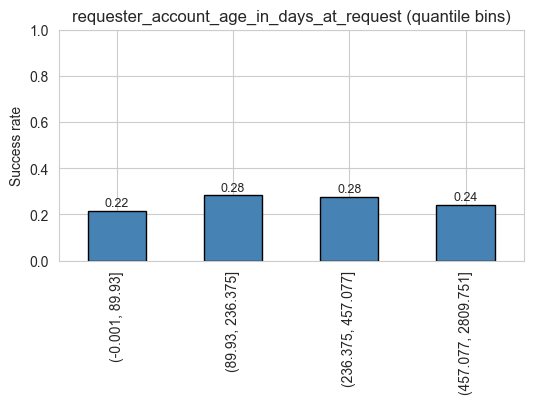

C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\228865018.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Success rate for requester_number_of_comments_at_request:
                success_rate
bin                         
(-0.001, 7.0]       0.212844
(7.0, 53.0]         0.267925
(53.0, 191.0]       0.270807
(191.0, 994.0]      0.267081
Bin counts:
bin         (-0.001, 7.0]  (7.0, 53.0]  (53.0, 191.0]  (191.0, 994.0]
n_requests           1635          795            805             805


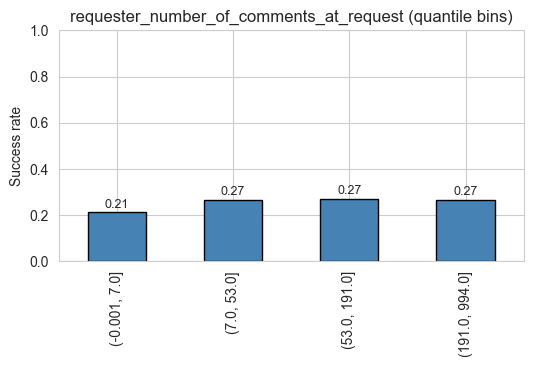

C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\228865018.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Success rate for requester_number_of_posts_at_request:
               success_rate
bin                        
(-0.001, 2.0]      0.214745
(2.0, 9.0]         0.288204
(9.0, 29.0]        0.252196
(29.0, 867.0]      0.267766
Bin counts:
bin         (-0.001, 2.0]  (2.0, 9.0]  (9.0, 29.0]  (29.0, 867.0]
n_requests           1709         746          797            788


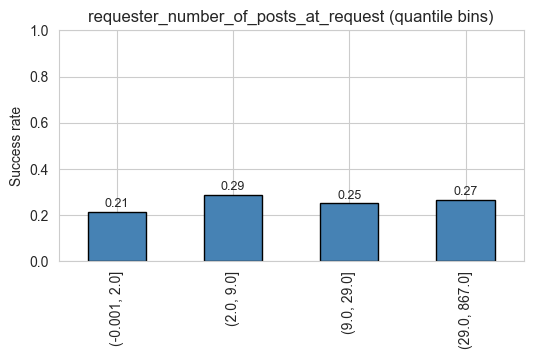

Success rate for requester_number_of_subreddits_at_request:
               success_rate
bin                        
(-0.001, 1.0]      0.172319
(1.0, 6.0]         0.258716
(6.0, 16.0]        0.304786
(16.0, 32.0]       0.262019
(32.0, 186.0]      0.263496
Bin counts:
bin         (-0.001, 1.0]  (1.0, 6.0]  (6.0, 16.0]  (16.0, 32.0]  \
n_requests           1091         545          794           832   

bin         (32.0, 186.0]  
n_requests            778  


C:\Users\mzouicha\AppData\Local\Temp\ipykernel_15812\228865018.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



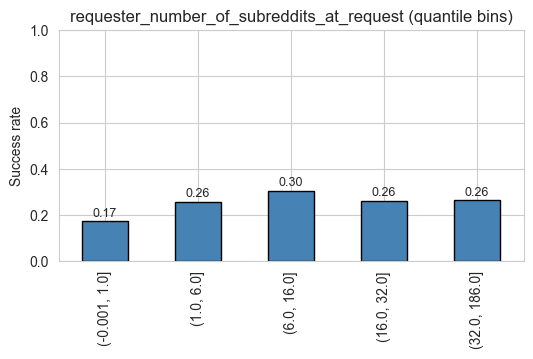

In [ ]:
sns.set_style("whitegrid")

num_vars = [
    "requester_upvotes_plus_downvotes_at_request",    # karma 
    "requester_upvotes_minus_downvotes_at_request",     # karma 
    "requester_account_age_in_days_at_request",         # account age
    "requester_number_of_comments_at_request",          # #comments
    "requester_number_of_posts_at_request",             # #posts
    "requester_number_of_subreddits_at_request",        # subreddit breadth
]

def success_bars(col, bins=5):
    df_temp = df[[col, "requester_received_pizza"]].copy()
    df_temp["bin"] = pd.qcut(df_temp[col], q=bins, duplicates="drop")
    
    rate = (df_temp.groupby("bin")["requester_received_pizza"]
              .mean()
              .rename("success_rate"))
    count = df_temp["bin"].value_counts().sort_index()
    
    print(f"Success rate for {col}:")
    print(rate.to_frame())
    print("Bin counts:")
    print(count.to_frame("n_requests").T)
    
    ax = rate.plot(kind="bar", figsize=(6,3), color="steelblue", edgecolor="black")
    ax.set_title(f"{col} (quantile bins)")
    ax.set_ylabel("Success rate")
    ax.set_xlabel("")
    ax.set_ylim(0,1)
    for i,v in enumerate(rate):
        ax.text(i, v+0.02, f"{v:.2f}", ha="center", fontsize=9)
        
    plt.show()

for var in num_vars:
    if df[var].nunique() > 8: 
        success_bars(var, bins=5)